<a href="https://colab.research.google.com/github/pavankumarchowdary35/Image_captioning_project/blob/main/caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
import glob
from PIL import Image
from time import time
from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from tensorflow.keras.layers import Bidirectional, add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical

In [ ]:
# Download images
!wget -c https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!unzip -qq Flickr8k_Dataset.zip

# Download captions
!wget -c https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_text.zip

In [3]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-09-04 14:27:28--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-09-04 14:27:28--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-09-04 14:27:28--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [4]:
token_path = "/content/Flickr8k.token.txt"
train_images_path = '/content/Flickr_8k.trainImages.txt'
test_images_path = '/content/Flickr_8k.testImages.txt'
images_path = '/content/Flicker8k_Dataset'
glove_path = '/content/glove.6B.200d.txt'

In [5]:
doc = open(token_path,'r').read()
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [6]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

Data cleaning

In [7]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

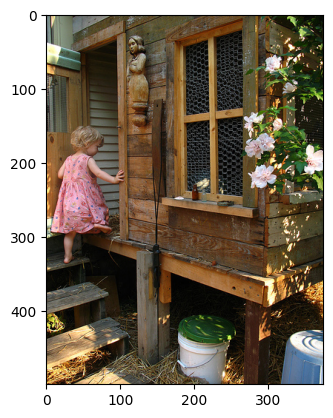

['a child in a pink dress is climbing up a set of stairs in an entry way ',
 'a girl going into a wooden building ',
 'a little girl climbing into a wooden playhouse ',
 'a little girl climbing the stairs to her playhouse ',
 'a little girl in a pink dress going into a wooden cabin ']

In [8]:
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+"/" +pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

Creating vocabulary of unique words

In [40]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8828


In [41]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [42]:
new_descriptions[0:410]

'1000268201_693b08cb0e a child in a pink dress is climbing up a set of stairs in an entry way \n1000268201_693b08cb0e a girl going into a wooden building \n1000268201_693b08cb0e a little girl climbing into a wooden playhouse \n1000268201_693b08cb0e a little girl climbing the stairs to her playhouse \n1000268201_693b08cb0e a little girl in a pink dress going into a wooden cabin \n1001773457_577c3a7d70 a black dog '

In [43]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

In [ ]:
train

In [47]:
img = glob.glob(images_path + '/*.jpg')

In [ ]:
img

In [49]:
import glob
import os

# List all image files in the specified directory
img = glob.glob(images_path + '/*.jpg')

# Read the training and testing file name lists
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

# Initialize lists to store training and testing images
train_img = []
test_img = []

# Extract and compare file names for training set
for i in img:
    filename = os.path.basename(i)  # Extracts the file name from the path
    if filename in train_images:
        train_img.append(i)

# Extract and compare file names for testing set
for i in img:
    filename = os.path.basename(i)  # Extracts the file name from the path
    if filename in test_images:
        test_img.append(i)

In [ ]:
img

In [ ]:
train_img

In [52]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

In [ ]:
train_descriptions

In [54]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [ ]:
all_train_captions

In [ ]:
train_descriptions

In [57]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

In [58]:
print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1659


In [59]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [60]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


In [67]:
embeddings_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            #print(word)
            coefs = np.asarray(values[1:], dtype='float32')
            #print(coefs)
            embeddings_index[word] = coefs


In [69]:
embeddings_index["hot"].shape

(200,)

In [70]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [73]:
embedding_matrix.shape

(1660, 200)

In [74]:
model = InceptionV3(weights='imagenet')

96112376/96112376 [==============================] - 2s 0us/step


In [75]:
model_new = Model(model.input, model.layers[-2].output)

In [80]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x


In [ ]:
def encode(image):
    image = preprocess(image)
    fea_vec = model_new.predict(image)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

In [ ]:
train_features

In [82]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 200)      332000      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [83]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [84]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [91]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos['/'+key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0


In [92]:
epochs = 30
batch_size = 3
steps = len(train_descriptions)//batch_size

In [93]:
generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/30
2000/2000 [==============================] - 236s 114ms/step - loss: 3.6894
Epoch 2/30
2000/2000 [==============================] - 227s 114ms/step - loss: 3.0300
Epoch 3/30
2000/2000 [==============================] - 221s 110ms/step - loss: 2.8335
Epoch 4/30
2000/2000 [==============================] - 222s 111ms/step - loss: 2.7138
Epoch 5/30
2000/2000 [==============================] - 224s 112ms/step - loss: 2.6312
Epoch 6/30
2000/2000 [==============================] - 226s 113ms/step - loss: 2.5644
Epoch 7/30
2000/2000 [==============================] - 225s 113ms/step - loss: 2.5142
Epoch 8/30
2000/2000 [==============================] - 233s 116ms/step - loss: 2.4716
Epoch 9/30
2000/2000 [==============================] - 229s 114ms/step - loss: 2.4348
Epoch 10/30
2000/2000 [==============================] - 233s 117ms/step - loss: 2.4062
Epoch 11/30
2000/2000 [==============================] - 227s 114ms/step - loss: 2.3798
Epoch 12/30
2000/2000 [==================

In [94]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

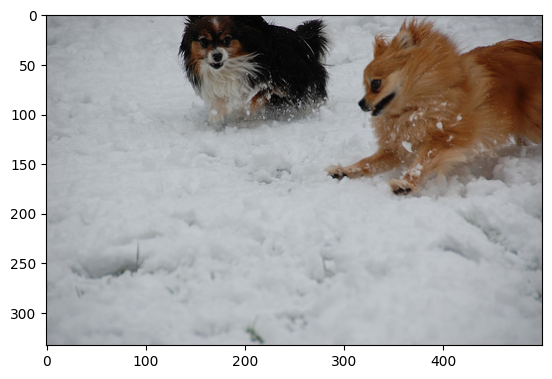

Greedy Search: a dog is running through the snow


In [98]:
pic = '/2398605966_1d0c9e6a20.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))

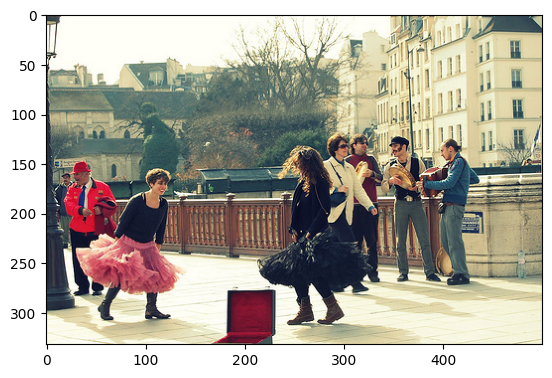

Greedy: a group of people are listening at a table outdoors


In [104]:
pic = list(encoding_test.keys())[2]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))

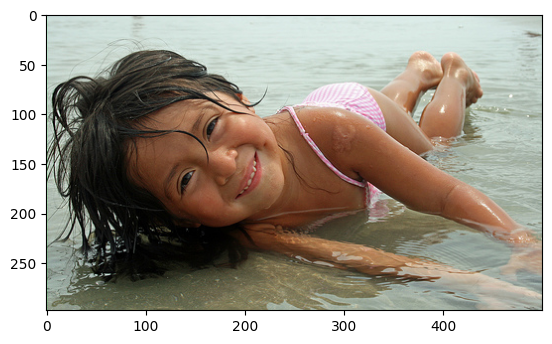

Greedy: a young girl in a pink swimsuit is playing in the water


In [108]:
pic = list(encoding_test.keys())[10]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))

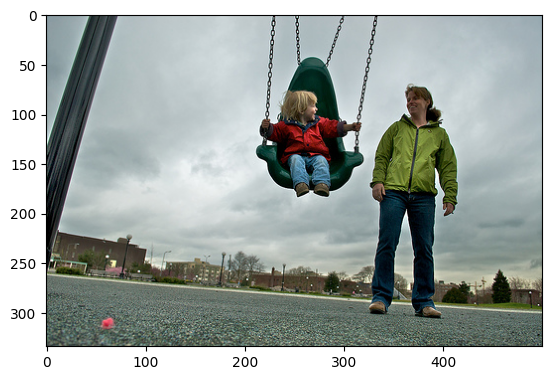

Greedy: a young boy is swinging on a rope swing


In [113]:
pic = list(encoding_test.keys())[100]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))

In [ ]:
2